In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mibitrans.analysis.mass_balance import mass_balance
from mibitrans.data.parameter_information import ElectronAcceptors
from mibitrans.data.parameter_information import UtilizationFactor
from mibitrans.data.parameters import AttenuationParameters
from mibitrans.data.parameters import HydrologicalParameters
from mibitrans.data.parameters import ModelParameters
from mibitrans.data.parameters import SourceParameters
from mibitrans.transport.models import Anatrans
from mibitrans.transport.models import Bioscreen
from mibitrans.transport.models import Mibitrans
from mibitrans.visualize.plot_line import breakthrough
from mibitrans.visualize.plot_line import centerline
from mibitrans.visualize.plot_line import transverse
from mibitrans.visualize.plot_surface import plume_2d
from mibitrans.visualize.plot_surface import plume_3d
from mibitrans.visualize.show_mass_balance import generate_mass_balance_tables
from mibitrans.visualize.show_mass_balance import visualize_mass_balance

The examples below uses example data originating from BIOSCREEN, the Excel based modeling software this package took inspiration from. As it was developed in the USA, length units are in ft. We'll use a conversion factor to express length in m instead.

In [ ]:
ft = 3.281 # factor to convert ft to m

### Input by dataclasses

mibitrans use dataclasses located in mibitrans.data.read to handle data input. This can be There are five input dataclasses, each for a different category of parameters. To avoid any mistakes, units of input parameters should be the ones specified. When using different units, make sure that they are consistent throughout the entire modelling process.

#### Hydrological parameters

Contains parameters that are inherent to the aquifer properties; flow velocity, porosity and dispersivity. Flow velocity can alternatively be calculated from the hydraulic conductivity and hydraulic gradient. 

In [ ]:

hydro = HydrologicalParameters(
    velocity=113.8/ft/365,   # Groundwater flow velocity, in [m/day]
    porosity=0.25,           # Effective soil porosity [-]
    alpha_x=13.3/ft,         # Longitudinal dispersivity, in [m]
    alpha_y=1.3/ft,          # Transverse horizontal dispersivity, in [m]
    alpha_z=0                # Transverse vertical dispersivity, in [m]
)

# Alternative by specifying hydraulic gradient and hydraulic conductivity
hydro = HydrologicalParameters(
    h_gradient=0.048,        # Hydraulic gradient [-]
    h_conductivity=0.495,    # Hydraulic conductivity [m/day]
    porosity=0.25,           # Effective soil porosity [-]
    alpha_x=13.3/ft,         # Longitudinal dispersivity, in [m]
    alpha_y=1.3/ft,          # Transverse horizontal dispersivity, in [m]
    alpha_z=0                # Transverse vertical dispersivity, in [m]
)

# And then check the value:
print("The calculated groundwater flow velocity is: ", hydro.velocity, r"m/d")

# Any other input parameters can be requested by specifying the argument;
print(f"The dispersivity values are: {hydro.alpha_x}m, {hydro.alpha_y}m and {hydro.alpha_z}m,"
      " for the x, y and z directions respectively.")

# When in doubt what input and attributes a dataclass has, use ClassName? to see the documentation:
HydrologicalParameters?

#### Attenuation parameters
Handles all parameters related to adsorption, diffusion and degradation.

##### Attenuation: retardation and diffusion
Retardation can be simply given as a value >= 1. Alternatively, the adsorption is calculated from the soil bulk density, paratition coefficient and the fraction of organic carbon in the soil. Note that calculation of retardation factor requires porosity as well, which is already provided in HydrologicalParameters. The calculation of retardation will therefore be automatically performed in the analytical equation. It can be manually calculated using the calculate_retardation method as well.

Here, molecular diffusion can be given as well. It is 0 by default.

In [4]:
att = AttenuationParameters(
    # Retardation factor for transported contaminants
    retardation=1
)

# Alternatively, calculate the retardation factor by supplying soil and contaminant properties
att = AttenuationParameters(
    # Soil bulk density in [g/m^3]
    bulk_density=1.7,
    # Partition coefficient of the transported contaminant to soil organic matter, in [m^3/g]
    partition_coefficient=38,
    # Fraction of organic material in the soil [-]
    fraction_organic_carbon=5.7e-5
)

# Calculate the retardation factor beforehand to see its value by specifying the porosity
att.calculate_retardation(porosity=hydro.porosity)

# And then check the value:
print("The calculated retardation value is: ", att.retardation)

att = AttenuationParameters(
    # Retardation factor for transported contaminants
    retardation=1,
    # Molecular diffusion, in [m2/day]
    diffusion=1e-5
)

The calculated retardation value is:  1.0147288


##### Attenuation: degradation parameters

Linear decay models only need either the contaminant decay rate or half life. Input for the instant reaction model is somewhat more involved, and is therefore done with a class method of the model classes.

In [43]:
att = AttenuationParameters(
    # Contaminant first order decay rate in [1/days]
    decay_rate=0.0127
)

# Alternatively, specify the contaminant half life
att = AttenuationParameters(
    # Contaminant half life, in [days]
    half_life=54.75,
)


For the examples below, we'll set the attenuation parameters to the desired settings

In [44]:
att = AttenuationParameters(
    # Soil bulk density in [g/m^3]
    bulk_density=1.7,
    # Partition coefficient of the transported contaminant to soil organic matter, in [m^3/g]
    partition_coefficient=38,
    # Fraction of organic material in the soil [-]
    fraction_organic_carbon=5.7e-5,
    # Molecular diffusion, in [m2/day]
    diffusion=0,
    # Contaminant half life, in [days]
    half_life=365#54.75,

)

##### Source parameters

Takes input of the dimensions of and concentrations at the contaminant source. The source is treated as a seperate phase, which dissolves into the groundwater over time. The source is assumed to be in symmetrical in its center, and concentrations decrease from the center to the fringes. Furthermore, the source is assumed to be constant over its depth. The transverse horizontal dimension (or width) of the source is divided into zones, which span a certain distance measured from the center of the source, each with an associated concentration. For example, a source can have a concentration of $10g/m^3$ $7m$ left and right from the source center, and a concentration of $5g/m^3$ up to $20m$ from the source center. This would then be entered as source_zone_boundary = $[7,20]$ and source_zone_concentration = $[10,5]$. The source can be a single zone with a single concentration as well.

By giving a total mass of the contaminant source, the amount of solid-phase contaminant, and with that, the source zone concentrations, diminish over time. The rate at which this occurs depends on the flow velocity in the aquifer and the size of the source zone. The source zone can be set to be considered infinite as well, meaning that the concentrations will not diminish over time.

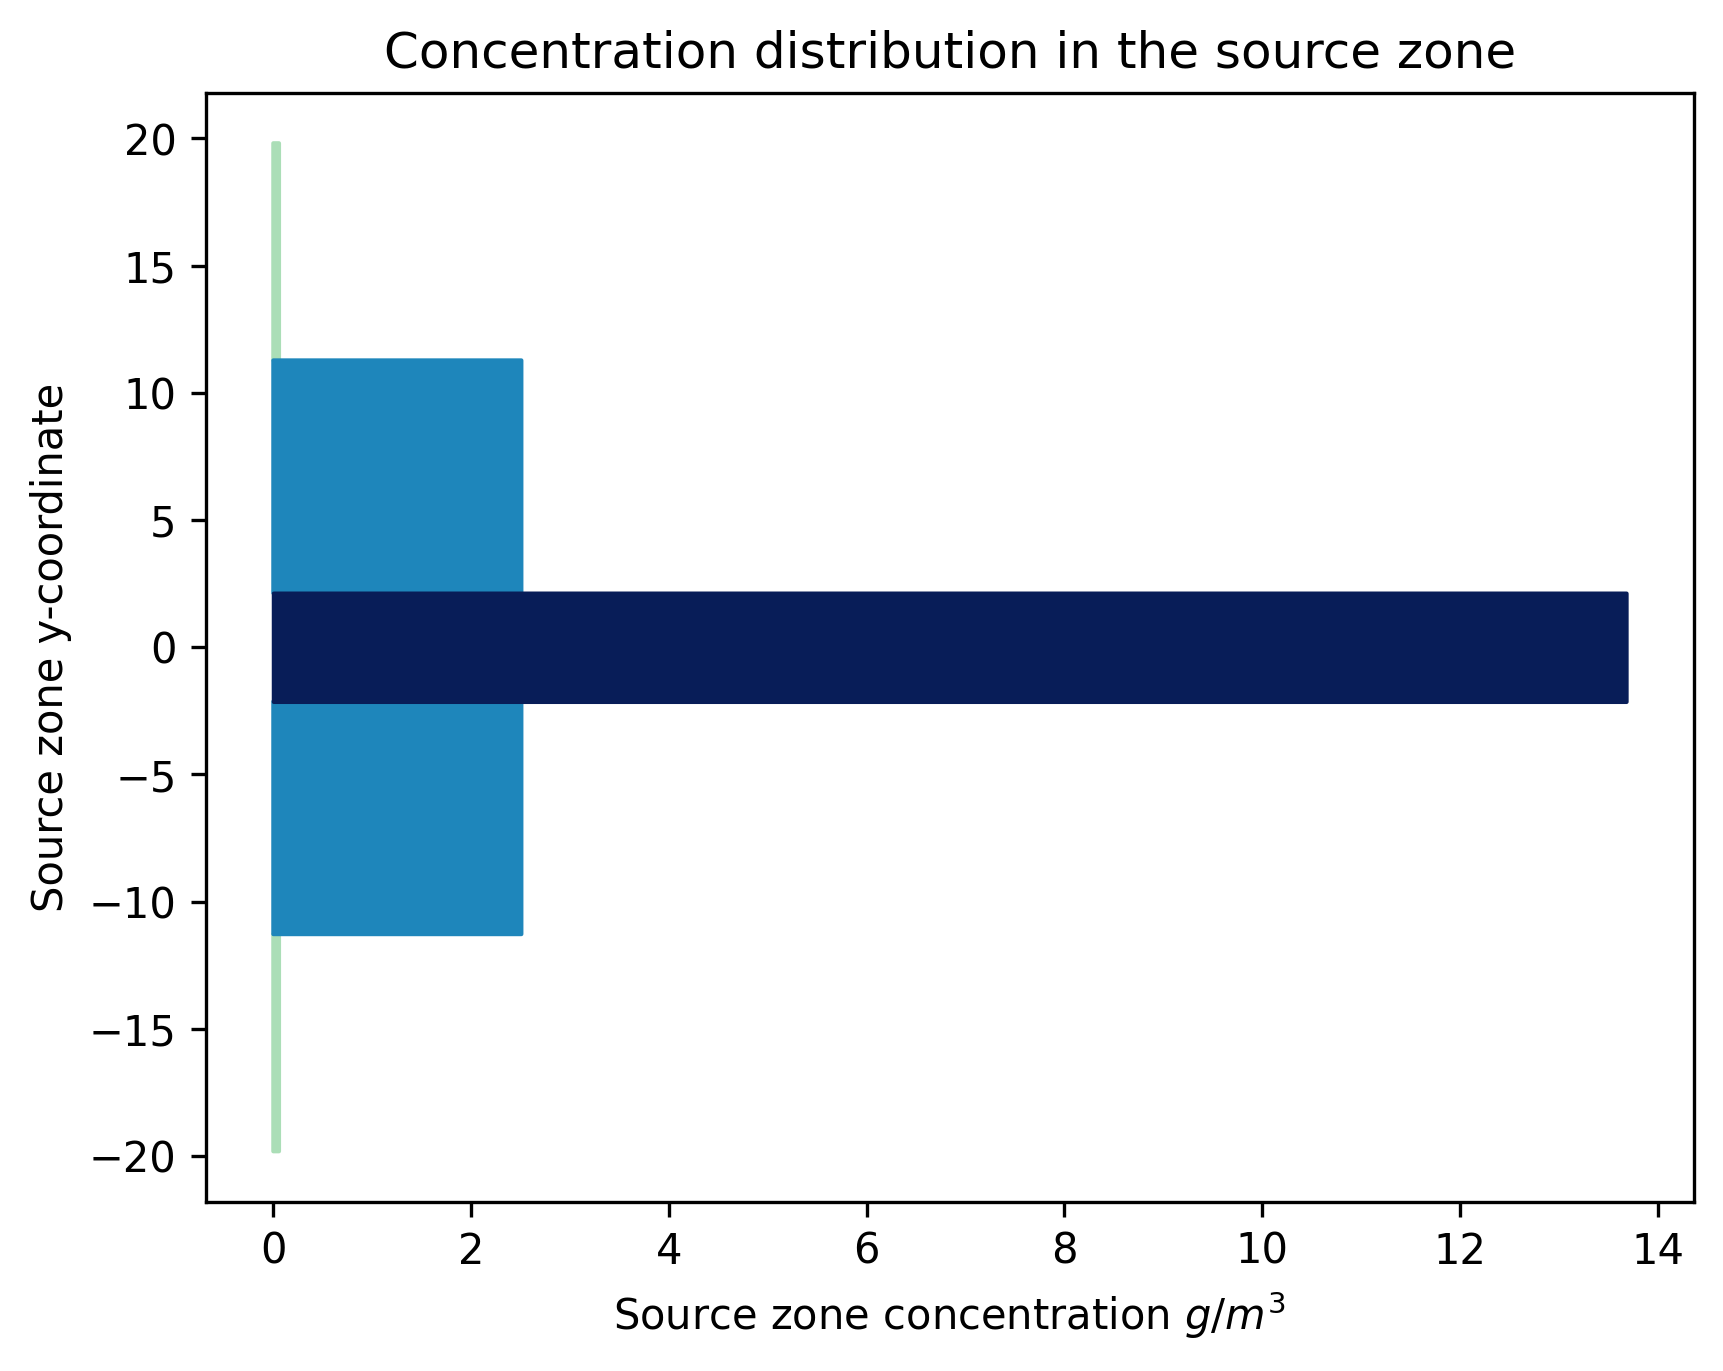

In [7]:
# Input for a simple source zone with a width of 19.8m (65ft) and a continuous input (infinite source mass)
source = SourceParameters(
    # Source zone boundaries, in [m] (simply using a float instead of a numpy array for
    # single source zone input will work as well)
    source_zone_boundary=np.array([65/ft]),
    # Source zone concentrations, in [g/m^3]
    source_zone_concentration=np.array([5]),
    # Source depth extent, in [m]
    depth=10/ft,
    # Source mass, considered infinite
    total_mass="inf"
)

# Alternatively, specify a source mass to allow for source decay
source = SourceParameters(
    source_zone_boundary=np.array([7/ft, 37/ft, 65/ft]),
    source_zone_concentration=np.array([13.68, 2.508, 0.057]),
    depth=10/ft,
    total_mass=2000000
)

# Visualize what the source zone looks like to check your input:
source.visualize()
plt.show()

##### Model parameters

Accepts input for the model dimensions and discretization. Model length is the extent in the (x) direction parallel to the groundwater flow direction. The model width is the extent of the model perpendicular (y) to the groundwater flow direction. Step size of the spatial dimensions is handled with dx and dy. Ensure that the source zone fits inside of the given model width. If step sizes are not given, a ratio of model_length (1/100), model_width (1/50) and model_time (1/10) is used by default.

In [8]:
model = ModelParameters(
    # Model extent in the longitudinal (x) direction in [m].
    model_length = 320/ft,
    # Model extent in the transverse horizontal (y) direction in [m].
    model_width = 100/ft,
    # Model duration in [days].
    model_time = 6 * 365,
    # Model grid discretization step size in the longitudinal (x) direction, in [m].
    dx = 1/ft,
    # Model grid discretization step size in the transverse horizontal (y) direction, in [m].
    dy = 1/ft,
    # Model time discretization step size, in [days]
    dt = 365 / 5
)

##### Input checking

The dataclass inputs evaluates if the required input parameters are present, if they are of the correct data type and if they are in the expected domain.

In [9]:
# If not all required parameters are specified, an error will be shown;
# HydrologicalParameters needs the porosity, longitudinal dispersivity and transverse horizontal dispersivity as well.
fake_hydro = HydrologicalParameters(velocity = 1)

MissingValueError: HydrologicalParameters missing 3 arguments: ['porosity', 'alpha_x', 'alpha_y'].

In [ ]:
# If the input datatype is not what is expected; source_zone_concentration expects a numpy array
# of the same length as the array given in source_zone_boundary.
fake_source = SourceParameters(
    source_zone_boundary = np.array([1,2,3]),
    source_zone_concentration = "this is a string, not an array",
    depth = 10,
    total_mass = "inf",
)

In [ ]:
# Same goes for if the input parameter has a value outside its valid domain; retardation should have a value >= 1
fake_att = AttenuationParameters(
    retardation = 0.1
)

### Analytical models

Having entered the parameters, their objects can be passed to the transport equations. These models are classes located in mibitrans.transport.models. Currently, three models are implemented; 'Mibitrans', 'Anatrans' and 'Bioscreen'. These classes generate the model grid and do some prior parameter calculations. The model object can then be used to call attributes of the model or as input for other functions of mibitrans. Model results can be calculated using the 'run' method.

#### Mibitrans model

The Mibitrans model class uses the exact analytical solution implemented by Karanovic (2007) in the Excel based BIOSCREEN-AT, and added source depletion, akin to that implemented in its predecessor BIOSCREEN by Newell et al. (1997). This model is based on the Wexler (1992) solution. The Mibitrans model allows for the same method as used in BIOSCREEN-AT, but expands it by allowing multiple source zones (by means of superposition) and including the instant reaction model. These were present in the original BIOSCREEN, but not reimplemented in BIOSCREEN-AT. Using a single source zone in this model, and not using the instant reaction option will make the Mibitrans solution resolve to the equation described in Karanovic (2007). Which in turn resolves to the Wexler (1992) solution if source depletion is disabled.

As the namesake model of this package, it is the recommended model to use. The other models introduce a margin of error by making some assumptions. However, since this model requires evaluation of an integral, computation time might be longer, depending on model discretization. The exact nature of these differences is too much to go into detail here, but is elaborated upon in the theoretical background.

In [45]:
# Initializing the model object
mbt_object = Mibitrans(
    hydrological_parameters=hydro,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model
)

# Can use model object to request various attributes
print("x discretization: ", mbt_object.x)
print("Retarded flow velocity: ", mbt_object.rv)
print("x steps", len(mbt_object.x), "y steps", len(mbt_object.y), "t steps", len(mbt_object.t))

# Run the model once initialized
mbt_object.run()
# # Get resulting array with concentrations, and model x, y and t discretization from model object
# cxyt, x, y, t = ndeg.cxyt, ndeg.x, ndeg.y, ndeg.t
#
# # Instead, sample a specific location at any point along the plume and any point in time
# concentration = ndeg.sample(150, 0, 10*365)
# print("The concentration at 150m downstream from the source after 10 years is:", concentration, r"g/m^3")


x discretization:  [ 0.          0.30478513  0.60957025  0.91435538  1.21914051  1.52392563
  1.82871076  2.13349589  2.43828101  2.74306614  3.04785126  3.35263639
  3.65742152  3.96220664  4.26699177  4.5717769   4.87656202  5.18134715
  5.48613228  5.7909174   6.09570253  6.40048766  6.70527278  7.01005791
  7.31484304  7.61962816  7.92441329  8.22919842  8.53398354  8.83876867
  9.14355379  9.44833892  9.75312405 10.05790917 10.3626943  10.66747943
 10.97226455 11.27704968 11.58183481 11.88661993 12.19140506 12.49619019
 12.80097531 13.10576044 13.41054557 13.71533069 14.02011582 14.32490094
 14.62968607 14.9344712  15.23925632 15.54404145 15.84882658 16.1536117
 16.45839683 16.76318196 17.06796708 17.37275221 17.67753734 17.98232246
 18.28710759 18.59189272 18.89667784 19.20146297 19.5062481  19.81103322
 20.11581835 20.42060347 20.7253886  21.03017373 21.33495885 21.63974398
 21.94452911 22.24931423 22.55409936 22.85888449 23.16366961 23.46845474
 23.77323987 24.07802499 24.38281

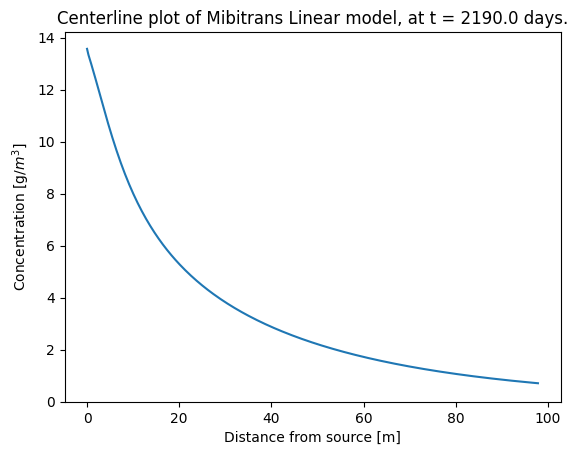

In [46]:
# Once the model has run, results are contained in the cxyt attribute
model_cxyt = mbt_object.cxyt

# cxyt is indexed as [time, y-position, x-position]
# Thus to get the concentration at the last time step, in the center of the plume for all x:
plume_center = model_cxyt[-1, 132//2, :]

# mibitrans has build-in visualization methods (see visualization section for more details).
mbt_object.centerline()
plt.show()

To perform the model with biodegradation modelled as an instant reaction, use the instant_reaction method. Input for the instant reaction model is somewhat more involved, needing electron donor and acceptor concentrations. For utilization factors (amount of electron donor/acceptor used/generated by biodegradation), the values for BTEX degradation are used by default. For more specifics about the underlying principles and assumptions, see the theory.

In [47]:
# For streamlined input, use the ElectronAcceptor dataclass;
ea = ElectronAcceptors(
    # Difference between background oxygen and current oxygen concentration in groundwater, in [g/m^3]
    delta_oxygen=1.65,
    # Difference between background nitrate and current nitrate concentration in groundwater, in [g/m^3]
    delta_nitrate=0.7,
    # Current ferrous iron concentration in groundwater, in [g/m^3]
    ferrous_iron=16.6,
    # Difference between background sulfate and current sulfate concentration in groundwater, in [g/m^3]
    delta_sulfate=22.4,
    # Current methane concentration in groundwater, in [g/m^3]
    methane=6.6
)

mbt_object.instant_reaction(electron_acceptors=ea)

# Can adapt utilization factors if needed
uf = UtilizationFactor(
    # utilization factor of oxygen, as mass of oxygen consumed per mass of biodegraded contaminant [g/g].
    util_oxygen=2,
    # utilization factor of nitrate, as mass of nitrate consumed per mass of biodegraded contaminant [g/g].
    util_nitrate=1,
    # utilization factor of ferrous iron, as mass of ferrous iron generated per mass of biodegraded contaminant [g/g].
    util_ferrous_iron=4,
    # utilization factor of sulfate, as mass of sulfate consumed per mass of biodegraded contaminant [g/g].
    util_sulfate=3,
    # utilization factor of methane, as mass of methane generated per mass of biodegraded contaminant [g/g].
    util_methane=5,
)

mbt_object.instant_reaction(electron_acceptors=ea, utilization_factor=uf)

# Alternatively, electron acceptors and/or utilization factors can be entered as a dictionary
mbt_object.instant_reaction(
    electron_acceptors={
        # Difference between background oxygen and current oxygen concentration in groundwater, in [g/m^3]
        "delta_oxygen":1.65,
        # Difference between background nitrate and current nitrate concentration in groundwater, in [g/m^3]
        "delta_nitrate":0.7,
        # Current ferrous iron concentration in groundwater, in [g/m^3]
        "ferrous_iron":16.6,
        # Difference between background sulfate and current sulfate concentration in groundwater, in [g/m^3]
        "delta_sulfate":22.4,
        # Current methane concentration in groundwater, in [g/m^3]
        "methane":6.6,
    }
)
print(mbt_object.biodegradation_capacity)
# Note that using instant_reaction also resets the utilization factor to default.
print("electron acceptor concentrations: ", mbt_object.electron_acceptors)
print("electron acceptor utilization factors: ", mbt_object.utilization_factor)

14.657298648118742
electron acceptor concentrations:  {'delta_oxygen': 1.65, 'delta_nitrate': 0.7, 'ferrous_iron': 16.6, 'delta_sulfate': 22.4, 'methane': 6.6}
electron acceptor utilization factors:  {'util_oxygen': 3.14, 'util_nitrate': 4.9, 'util_ferrous_iron': 21.8, 'util_sulfate': 4.7, 'util_methane': 0.78}


Be aware that electron acceptor concentrations and utilization factors can only be changed using the instant_reaction method. Changing the properties directly will not work.

Now that instant reaction parameters are provided, the model can be run:

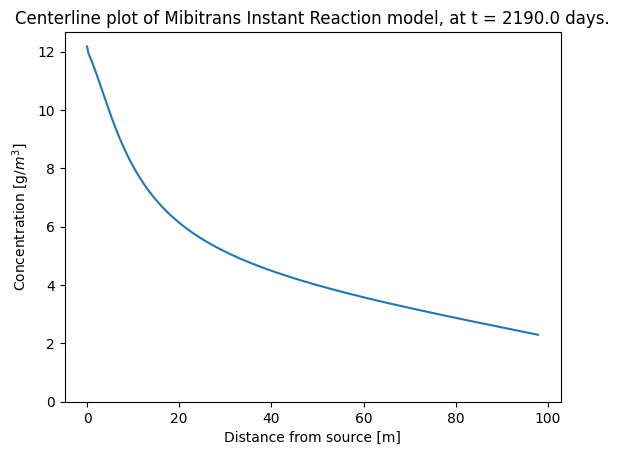

The current model mode is:  linear
The current model mode is:  instant_reaction


In [48]:
mbt_object.run()

mbt_object.centerline()
plt.show()

# Switch between instant reaction and linear model
mbt_object.mode = "linear"
print("The current model mode is: ", mbt_object.mode)
# Running now will show the results of the linear model
# Switch back to instant reaction as follows:
mbt_object.mode = "instant_reaction"
print("The current model mode is: ", mbt_object.mode)

Use the sample method to get the concentration at a specific location and time.

In [49]:
# Instead, sample a specific location at any point along the plume and any point in time
concentration = mbt_object.sample(
    x_position=100,
    y_position=0,
    time=10*365)
print("The concentration at 150m downstream from the source after 10 years is:", concentration, r"g/m^3")

The concentration at 150m downstream from the source after 10 years is: 3.2948140610638514 g/m^3


In [25]:
# Using the verbose flag, integration steps are printed to console.
# Usefull for longer runs to track progress
mbt_object = Mibitrans(
    hydrological_parameters=hydro,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model,
    verbose=True
)
mbt_object.run()

attenuation_parameters  got changed
integrating for source zone  0  and t = 73.0 days
integrating for source zone  0  and t = 146.0 days
integrating for source zone  0  and t = 219.0 days
integrating for source zone  0  and t = 292.0 days
integrating for source zone  0  and t = 365.0 days
integrating for source zone  0  and t = 438.0 days
integrating for source zone  0  and t = 511.0 days
integrating for source zone  0  and t = 584.0 days
integrating for source zone  0  and t = 657.0 days
integrating for source zone  0  and t = 730.0 days
integrating for source zone  0  and t = 803.0 days
integrating for source zone  0  and t = 876.0 days
integrating for source zone  0  and t = 949.0 days
integrating for source zone  0  and t = 1022.0 days
integrating for source zone  0  and t = 1095.0 days
integrating for source zone  0  and t = 1168.0 days
integrating for source zone  0  and t = 1241.0 days
integrating for source zone  0  and t = 1314.0 days
integrating for source zone  0  and t = 13

#### Other models

The two models other than the Mibitrans model share the same functionalities and properties as showcase above. The only difference is the implementation of calculation.

#### Anatrans model
The equation used for the Anatrans model has the assumption that C(x,y,z,t) = C(x,t) * C(y,t) * C(z,t). Then, the 3D ADE can be broken up in three separate differential equations which can be solved individually. For C(x,t) the solution is given in Bear (1979), C(y,t) and C(z,t) can be derived from Crank (1975). The Anatrans model is the combination of these solutions, with addition of source depletion, source superposition and instant reaction model, described in Newell et al. (1997). The solution of Newell et al. (1997) is based of the Domenico (1987) solution, a truncated version of the equation described above, which introduces an error with a size dependent on the ratio of flow velocity and longitudinal dispersivity. Anatrans instead uses the fully untruncated version.

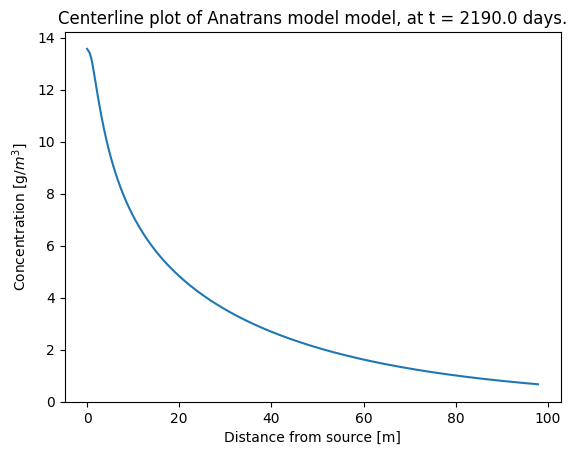

In [50]:
ana_object = Anatrans(
    hydrological_parameters=hydro,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model
)

ana_object.run()
ana_object.centerline()
plt.show()

#### Bioscreen model

This model is an exact implementation of the transport equations implemented in the BIOSCREEN screening model of Newell et al. (1997), which is based on the Domenico (1987) analytical model. Using a truncated version of the equation used in the Anatrans model. This model is implemented as a method of comparison with the original BIOSCREEN software. And is included for legacy reasons, since it is the first model implemented in the mibitrans package, serving as a basis for the other models. However, caution should be taken when using this model, since a varying error is introduced by using the truncated analytical solution. The error is most prominent for shorter times and distances from the source, and depends on the ratio of flow velocity and longitudinal dispersivity. For modelling, the Anatrans (untruncated approximate solution) and Mibitrans (exact analytical solution) models are recommended instead.

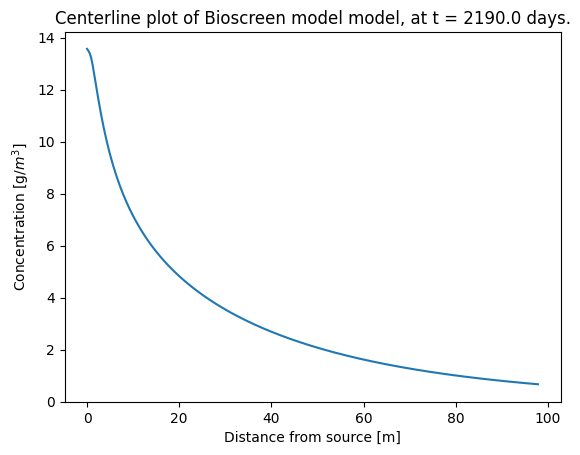

In [51]:
bio_object = Bioscreen(
    hydrological_parameters=hydro,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model
)
bio_object.run()
bio_object.centerline()
plt.show()

The model class check if they receive all required and the correct input dataclasses, ensuring model calculations will be performed without error.

In [52]:
# Will not work; hydrological_parameters should be a HydrologicalParameters class object.
fake_mbt = Mibitrans(
    hydrological_parameters=model,
    attenuation_parameters=att,
    source_parameters=source,
    model_parameters=model
)

TypeError: Input argument hydrological_parameters should be <class 'mibitrans.data.parameters.HydrologicalParameters'>, but is <class 'mibitrans.data.parameters.ModelParameters'> instead.

## Visualization

Mibitrans has various ways to visualize the model results. Above the centerline plot was already showcased, which plots the concentration distribution over the center of the contaminant plume. Plotting can be performed either as class method (i.e. model_object.centerline), or by calling the centerline function specifically; (i.e. centerline(model_object). The 1D plotting functions are located in mibitrans.visualize.plot_line. Multidimensional plots are located in mibitrans.visualize.plot_surface.

In [53]:
# Lets make some different model objects to use in the plotting, takes a couple of seconds to run

#Mibitrans model
mbt_lineardecay = Mibitrans(hydro, att, source, model)
mbt_lineardecay.run()

mbt_instant = Mibitrans(hydro, att, source, model)
mbt_instant.instant_reaction(electron_acceptors=ea)
mbt_instant.run()

mbt_nodecay = Mibitrans(hydro, att, source, model)
mbt_nodecay.attenuation_parameters.decay_rate = 0
mbt_nodecay.run()

#Anatrans model
ana_lineardecay = Anatrans(hydro, att, source, model)
ana_lineardecay.run()

ana_instant = Anatrans(hydro, att, source, model)
ana_instant.instant_reaction(electron_acceptors=ea)
ana_instant.run()

ana_nodecay = Anatrans(hydro, att, source, model)
ana_nodecay.attenuation_parameters.decay_rate = 0
ana_nodecay.run()

#Bioscreen model
bio_lineardecay = Bioscreen(hydro, att, source, model)
bio_lineardecay.run()

bio_instant = Bioscreen(hydro, att, source, model)
bio_instant.instant_reaction(electron_acceptors=ea)
bio_instant.run()

bio_nodecay = Bioscreen(hydro, att, source, model)
bio_nodecay.attenuation_parameters.decay_rate = 0
bio_nodecay.run()



#### Plotting centerline

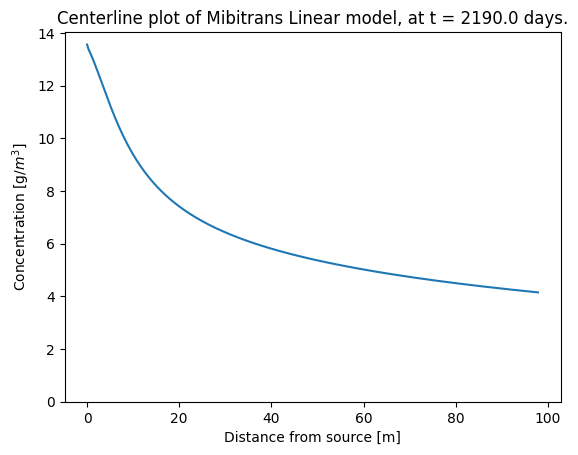

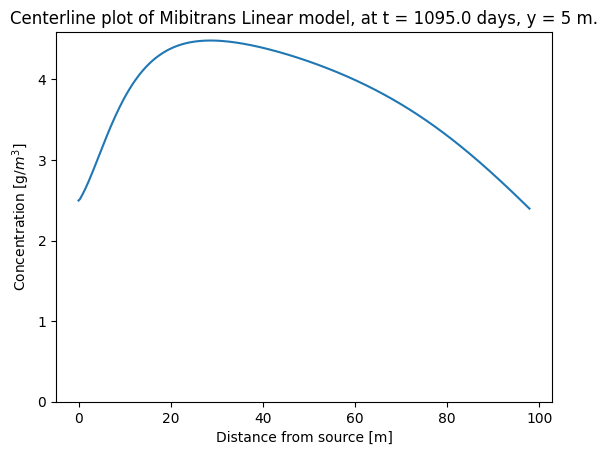

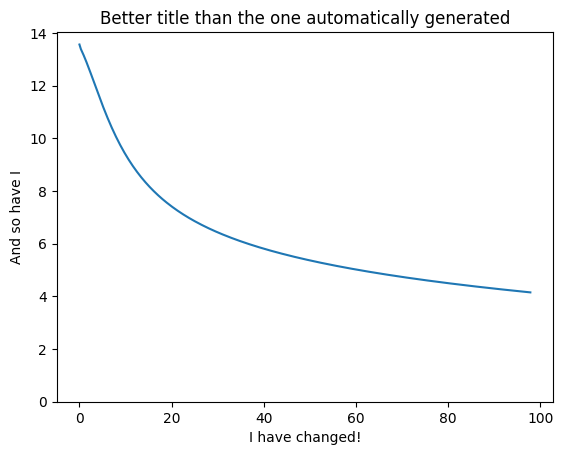

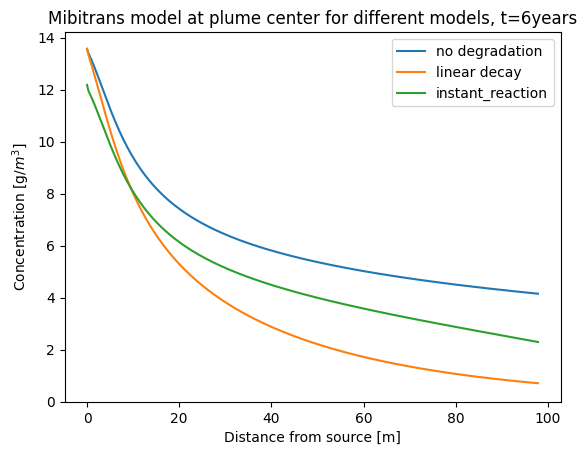

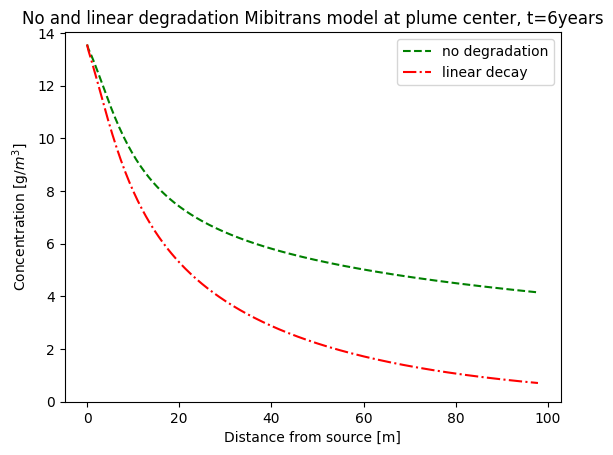

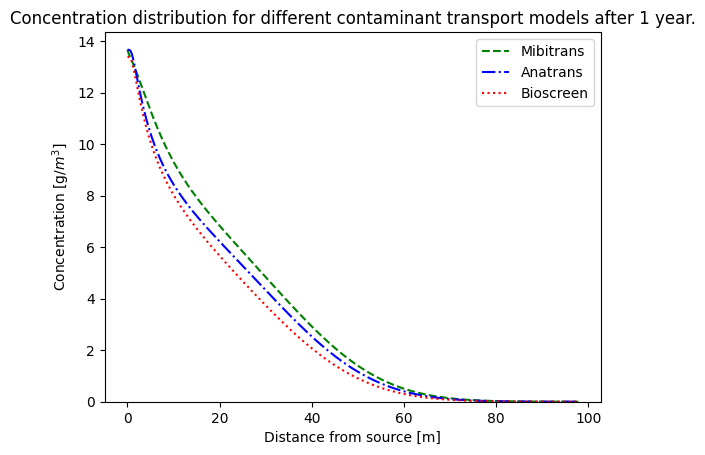

In [59]:
# Pass model object to plotting function, by default, the last time step is used.
centerline(mbt_nodecay)
plt.show()

# If you want to plot somewhere and sometime specific, use the time and y_position arguments.
# It gives the concentration profile at the step closest to what you specified.
centerline(mbt_nodecay, time=3*365, y_position=5)
#plt.title("No degradation Domenico model 5m away from center, t=6years")
plt.show()

# If you want you can change the plot settings to the ones you prefer
centerline(mbt_nodecay, time=6*365)
plt.title("Better title than the one generated automatically")
plt.xlabel("I have changed!")
plt.ylabel("And so have I")
plt.show()

legend = ["no degradation", "linear decay", "instant reaction"]

# Instead of a single model, all line visualization functions accept a list of models to be displayed
# together in a single plot.
centerline([mbt_nodecay, mbt_lineardecay, mbt_instant], time=6*365, legend_names=legend)
plt.title("Mibitrans model at plume center for different models, t=6years")
plt.show()

# Keyword arguments for plt.plot can be passed on through the function
# Calling function separately per model gives more control over plot layout
centerline(mbt_nodecay, time=6*365, linestyle="--", color="green", label=legend[0])
centerline(mbt_lineardecay, time=6*365, linestyle="-.", color="red", label=legend[1])
plt.title("No and linear degradation Mibitrans model at plume center, t=6years")
plt.legend()
plt.show()

# Alternatively, use the inherent plotting modules of the model objects
mbt_nodecay.centerline(time = 365, linestyle="--", color="green", label="Mibitrans")
ana_nodecay.centerline(time = 365, linestyle="-.", color="blue", label="Anatrans")
bio_nodecay.centerline(time = 365, linestyle=":", color="red", label="Bioscreen")
plt.title("Concentration distribution for different contaminant transport models after 1 year.")
plt.legend()
plt.show()


#### Plotting transverse distribution

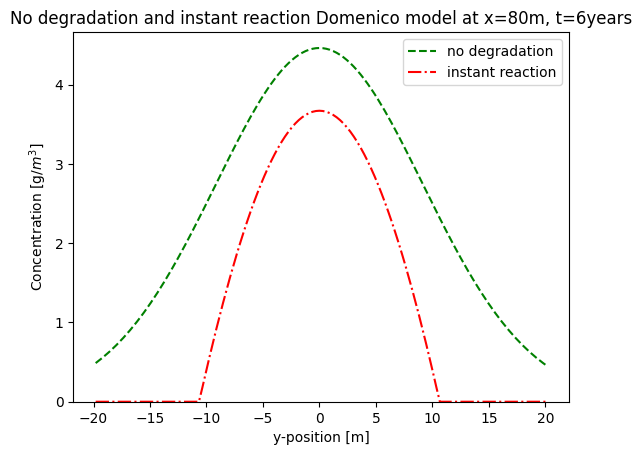

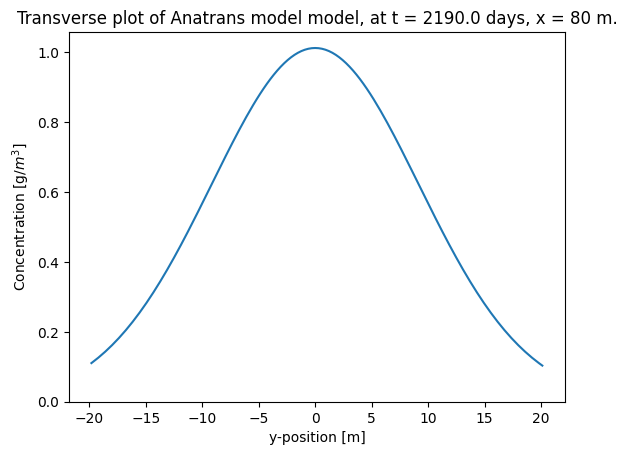

In [61]:
# Concentration distribution can also be plotted in the transverse direction
transverse(ana_nodecay, x_position=80, time=6*365, linestyle="--", color="green", label="no degradation")
transverse(ana_instant, x_position=80, time=6*365, linestyle="-.", color="red", label="instant reaction")

plt.title("No degradation and instant reaction Domenico model at x=80m, t=6years")
plt.legend()
plt.show()

# Or using the class methods
ana_lineardecay.transverse(x_position=80, time=6*365)
plt.show()

#### Plotting breakthrough curve

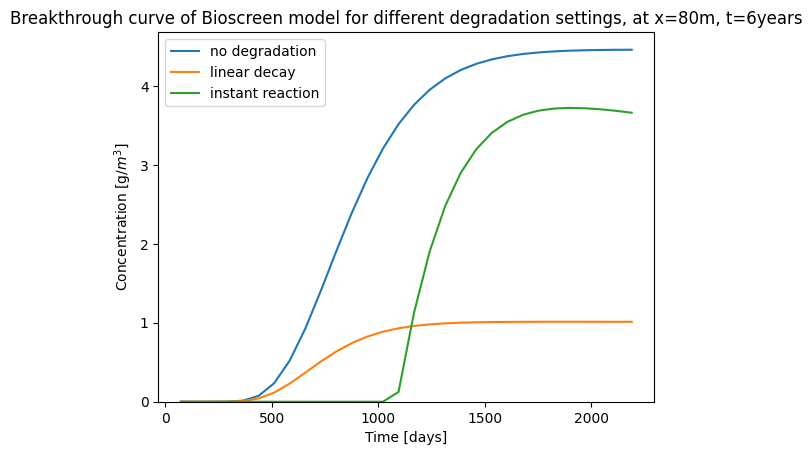

In [63]:
# Concentration distribution can also be plotted in the transverse direction
breakthrough([bio_nodecay, bio_lineardecay, bio_instant], x_position=80,
             legend_names=["no degradation", "linear decay", "instant reaction"])
plt.title("Breakthrough curve of Bioscreen model for different degradation settings, at x=80m, t=6years")
plt.show()



#### Plotting in 2D

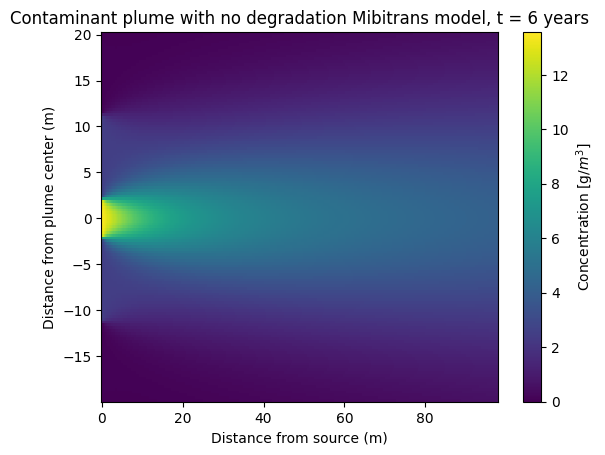

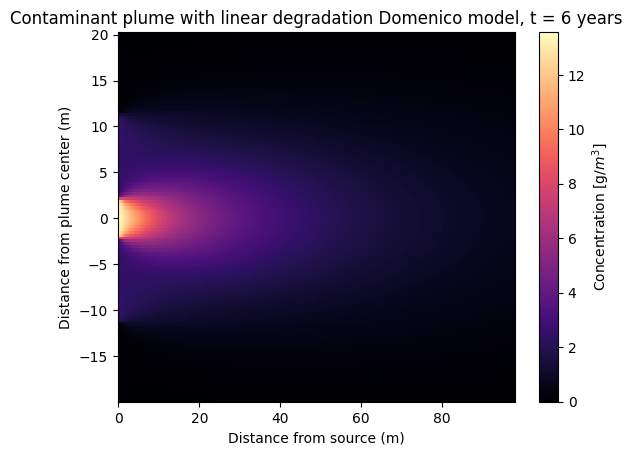

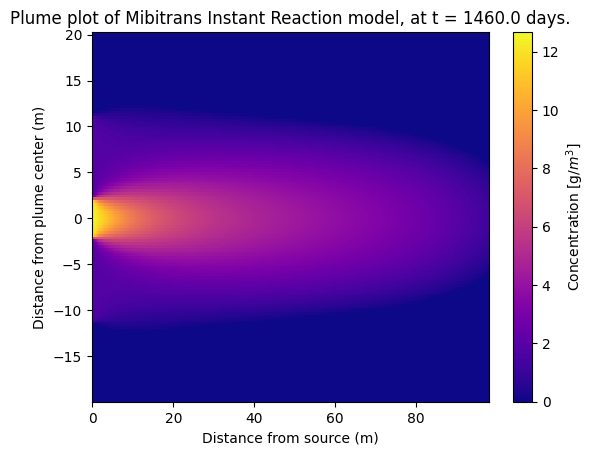

In [66]:
# Plot the x and y concentration distribution for the Mibitrans model, uses plt.pcolormesh
plume_2d(mbt_nodecay, time=6*365)
plt.title("Contaminant plume with no degradation Mibitrans model, t = 6 years")
plt.show()

# Function passes plt.colormesh keyword arguments
plume_2d(mbt_lineardecay, time=6*365, cmap="magma")
plt.title("Contaminant plume with linear degradation Domenico model, t = 6 years")
plt.show()

# Once again also can be accessed through the class method
mbt_instant.plume_2d(time=4*365, cmap="plasma")
plt.show()

#### Plotting 2D in 3D

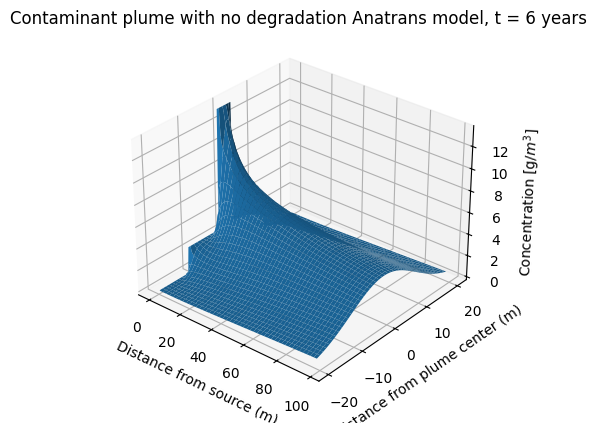

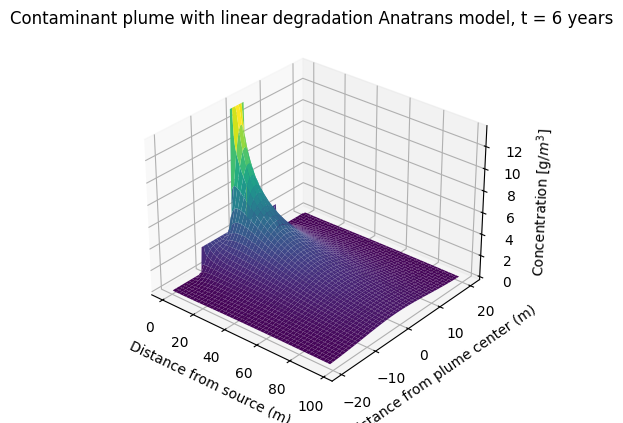

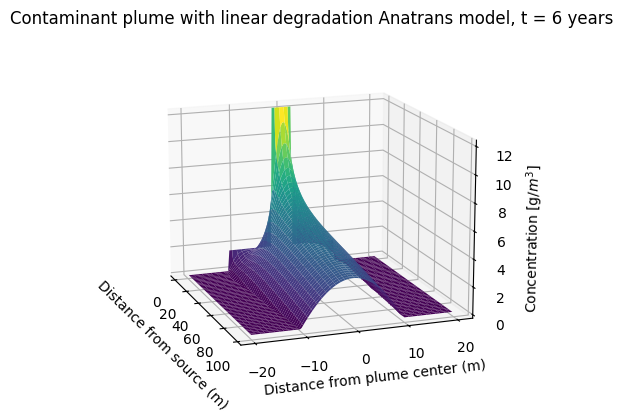

In [68]:
# Plot the x and y concentration distribution for no degradation decay model, uses plot_surface
plume_3d(ana_nodecay, time=6*365)
plt.title("Contaminant plume with no degradation Anatrans model, t = 6 years")
plt.show()

# Function passes plot_surface keyword arguments
plume_3d(ana_lineardecay, time=6*365, cmap="viridis")
plt.title("Contaminant plume with linear degradation Anatrans model, t = 6 years")
plt.show()

# Function returns 'ax' object, use this to change view point of plot
# And can be accessed through class methods
ax = ana_instant.plume_3d(time=6*365, cmap="viridis")
plt.title("Contaminant plume with linear degradation Anatrans model, t = 6 years")
ax.view_init(elev=15, azim=340)
plt.show()



#### Animate plots

All plots mentioned above in the visualization section have the option to be animated, which also can be saved as a file. Multiple models can be combined in a single animation. Make sure that parameters passed to the functions are inside the domain of all models. As each animation frame is a model time step, all models should have the exact same dt, otherwise, the animation will not show the correct temporal change in concentration.

In [69]:
# Needed to show animations in Jupyter Notebooks
%matplotlib notebook

In [70]:
# Output needs to be assigned to variable for animation to work
ani = centerline([mbt_nodecay, mbt_lineardecay, mbt_instant], time=6*365, legend_names=legend, animate=True)
plt.show()

# Animation of breakthrough curve instead shows a timelapse of drawing of each curve
ani1 = breakthrough([bio_nodecay, bio_lineardecay, bio_instant], x_position=20, legend_names=legend, animate=True)
plt.show()

# For the 3d surface plot, an entirely new plot needs to be generated per time step
# This can cause slightly longer execution times
ani2 = ana_instant.plume_3d(time=6*365, animate=True, cmap="viridis")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save animation as .gif (or other desired file format), this may take a while
# Adjust animation speed with optional fps argument
ani2.save("plume_animation.gif", fps=10)

## Mass balance

To gain numerical information about mass transport in the model area, use the mass balance module in mibitrans.analysis.mass_balance. This returns a dictionary with mass values of each relevant model component (which varies depending on the model), in grams. Use the module mibitrans.visualization.show_mass_balance to show the mass balance in the form of a table.

In [72]:
# Set up mass balance object with given transport parameters
mb = mass_balance(mbt_nodecay, time=6*365)
# The dictionary can be printed as is, but it is not convenient for visualization
print("Mass balance as dictionary:", mb)
# Alternatively, it can visualized by the mass balance visualization module
visualize_mass_balance(mb)
# Furthermore, the dictionary can be accessed to do your own analysis or visualization.
print("The source mass after 6 years is:", mb["source_mass_t"], "g")

Mass balance as dictionary: {'time': np.float64(2190.0), 'source_mass_0': 2000000, 'source_mass_t': np.float64(1983383.9240515507), 'source_mass_change': np.float64(16616.075948449317), 'plume_mass_no_decay': np.float64(7581.554834926156), 'transport_outside_extent_nodecay': np.float64(9034.521113523162)}
MASS BALANCE FOR t = 2190.0
+-----------------+-----------+
|   Source decay  |  Mass (g) |
+-----------------+-----------+
|    mass t = 0   |  2000000  |
| mass t = 2190.0 | 1983383.9 |
|    delta mass   |  16616.1  |
+-----------------+-----------+
+---------------------------------------+----------+
|                No decay               | Mass (g) |
+---------------------------------------+----------+
|               plume mass              |  7581.6  |
| mass transported outside model extent |  9034.5  |
+---------------------------------------+----------+
The source mass after 6 years is: 1983383.9240515507 g


In [73]:
# The function generate_mass_balance_tables generates the tables printed by visualize_mass_balance.
# You can access and change the tables themselves as a prettytable object by calling this function instead.
table_source, table_nodecay, table_lindecay, table_instant, table_electron = generate_mass_balance_tables(mb)

table_source.add_row(["additional parameter", 1000])
print(table_source)

+----------------------+-----------+
|     Source decay     |  Mass (g) |
+----------------------+-----------+
|      mass t = 0      |  2000000  |
|   mass t = 2190.0    | 1983383.9 |
|      delta mass      |  16616.1  |
| additional parameter |    1000   |
+----------------------+-----------+
